In [50]:
import numpy as np
#from lvmdrp.core.rss import RSS, loadRSS
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.io import ascii
#from astropy.table import Table
import matplotlib.colors as mcolors
c = c = list(mcolors.XKCD_COLORS.values())

from astropy.stats import sigma_clip

from scipy.optimize import least_squares

def vacuum_to_air(lambda_vac):
    """
    Vacuum-to-air wavelength conversion

    Args:
        lambda_vac: vacuum wavelength in Angstrom

    Returns:
        lambda_air: air wavelength in Angstrom

    Donald Morton (2000, ApJ. Suppl., 130, 403)
    """

    s = 1e4 / lambda_vac
    n = 1 + 0.0000834254 + 0.02406147 / (130 - s ** 2) + 0.00015998 / (38.9 - s ** 2)
    lambda_air = lambda_vac / n
    return lambda_air

def air_to_vacuum(lambda_air):
    """
    Air-to-vacuum wavelength conversion

    Args:
        lambda_air: air wavelength in Angstrom

    Returns:
        lambda_vac: vacuum wavelength in Angstrom
    """

    s = 1e4 / lambda_air
    n = 1 + 0.00008336624212083 + 0.02408926869968 / (130.1065924522 - s**2) + 0.0001599740894897 / \
        (38.92568793293 - s**2)
    lambda_vac = lambda_air * n
    return lambda_vac

data = ascii.read("lvm_sky_lines_all.dat", format='basic')


In [2]:
data.colnames

['wave',
 'flux_lvm',
 'flux_eso',
 'trans',
 'type',
 'electronic_state',
 'rotational_upper_level']

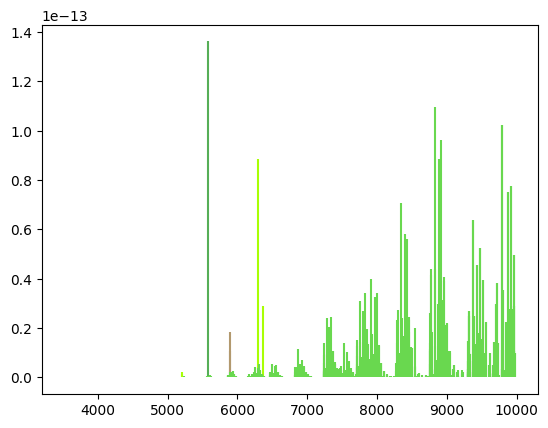

In [3]:
sys = data['type']
for i in range(np.min(sys), np.max(sys)):
    m = sys==i
    plt.vlines(data['wave'][m], np.zeros_like(data['wave'])[m], data['flux_lvm'][m], colors=c[i])


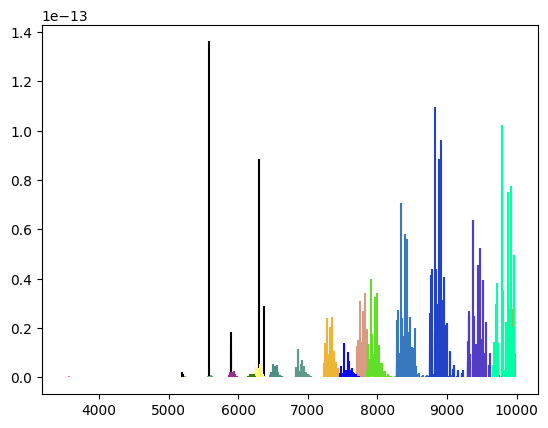

In [7]:
sys = data['electronic_state']
m = sys==-999
plt.vlines(data['wave'][m], np.zeros_like(data['wave'])[m], data['flux_lvm'][m], colors='k')
for i in range(0, np.max(sys)):
    m = sys==i
    plt.vlines(data['wave'][m], np.zeros_like(data['wave'])[m], data['flux_lvm'][m], colors=c[i])


In [51]:
def polynomial_fit_with_outliers(wave, flux, degree=3, sigma_lower=3, sigma_upper=3, grow=0, max_iter=10):
    """
    Perform a polynomial fit to the total spectrum while iteratively removing outliers.

    Parameters:
        wave, flux: input spectrum
        degree (int): Degree of the polynomial fit.
        sigma_lower (float): Lower sigma value for sigma-clipping to identify outliers.
        sigma_upper (float): Upper sigma value for sigma-clipping to identify outliers.
        grow (int): Number of pixels to grow the mask of clipped values.
        max_iter (int): Maximum number of iterations for outlier removal.

    Returns:
        fitted flux, mask
    """

    # Initial fit
    coefficients = np.polyfit(wave, flux, degree)
    fitted_flux = np.polyval(coefficients, wave)

    # Iterate until convergence or max_iter
    for _ in range(max_iter):
        # Compute residuals
        residuals = flux - fitted_flux

        # Perform sigma clipping
        mask = sigma_clip(residuals, sigma_lower=sigma_lower, sigma_upper=sigma_upper, grow=grow).mask

        # Update masked spectrum table
        masked_wave = wave[~mask]
        masked_flux = flux[~mask]

        # Perform polynomial fit
        coefficients = np.polyfit(masked_wave, masked_flux, degree)

        # Evaluate polynomial fit on the wavelength grid
        fitted_flux = np.polyval(coefficients, wave)

    return fitted_flux, mask

def line_group_residuals(x, w, f):
    return line_group(x,w) - f

def line_group(x, w):
    y = np.zeros_like(w)
    for i in range(0, len(x), 2):
        amp = x[i]
        ctr = x[i+1]
        # sig = x[i+2]
        sig = 1.5
        y = y + amp * np.exp( -((w - ctr)/sig)**2)
    return y

def fit_line_group(lines_w, lines_f, w, f):
    guess = []
    for i in range(len(lines_w)):
        guess += [lines_f[i], lines_w[i]]
    res = least_squares(line_group_residuals, guess, args = (w, f))

    return res

def get_lines_and_continuum(spec=2234):
    with fits.open('XCframe_1.1.1_3469_31300_1.fits') as hdu:
        wc = hdu['WAVE'].data
        sc = hdu['FLUX'].data[spec,]
        # subtract continuum
        cont, _ = polynomial_fit_with_outliers(wc, sc, degree=3, sigma_lower=2, sigma_upper=3)
        lines_only = sc - cont
        #hdu.info()
        return wc, sc, cont, lines_only

# fig = plt.figure(figsize=(12,4))
# sys = data['electronic_state']
# for i in range(0, np.max(sys)):
#     m = sys==i
#     if not any(m):
#         continue
#     flux = data['flux_lvm'][m]
#     # wave = vacuum_to_air(data['wave'][m])
#     wave = data['wave'][m]
#     #plt.vlines(wave, np.zeros_like(data['Wavelength'])[m], flux, colors=c[i])
#     #plt.plot(wc, lines_only, linewidth=1, color='k')
#     res = fit_line_group(wave, flux, wc, lines_only)
#     fit = line_group(res.x, wc)
#     plt.plot(wc, fit+cont, linewidth=2, color=c[i])


# plt.plot(wc,sc,'k-',linewidth=1)
# plt.plot(wc,cont,'r-',linewidth=1)
# plt.semilogy()
# plt.ylim(3e-15,1e-12)



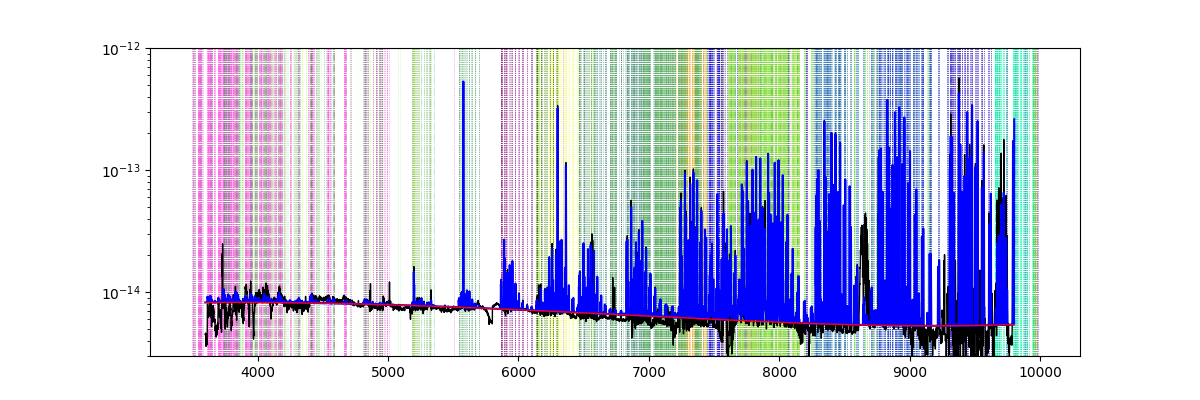

In [66]:
from scipy import sparse
%matplotlib inline

def fit_line_groups(wc, sc, cont, lines_only, plot=True):
    fact = np.sqrt(2.0 * np.pi)
    sigma = 1.5/2.35
    kernel_width = 5 # in pix, should exceed 4 sigma
    vI = []
    vJ = []
    vV = []

    sys = data['electronic_state'] # fix groups for type!=4,5
    typ = data['type']
    sys[sys==-999] = typ[sys==-999]

    ngroup = 0
    for i in range(0, np.max(sys)):
        m = sys==i
        if not any(m):
            continue
        ngroup += 1
        flux = data['flux_eso'][m]
        # wave = vacuum_to_air(data['wave'][m])
        wave = data['wave'][m]
        for line in range(len(wave)):
            if(wave[line]>wc[0] and wave[line] < wc[-1]):
                pix = np.where(wc<wave[line])[0][-1]
                for yy in range(pix-kernel_width,pix+kernel_width+1):
                    yy = np.clip(yy,0,len(wc)-1)
                    v = np.exp(-0.5 * ((wc[yy]-wave[line]) / sigma) ** 2) / (fact * sigma)
                    if v>=0.00001:   # make non-zero and positive definite
                        vI.append(ngroup)
                        vJ.append(yy)
                        vV.append(flux[line]*v / 1.0) #self._error[yy])

    B = sparse.csc_matrix((vV, (vJ, vI)), shape=(len(wc), ngroup+1))

    # plt.imshow(B.toarray(),aspect=0.002,vmin=0,vmax=1e-16)
    # plt.show()

    guess_flux = np.ones(ngroup+1) * 1e-13
    # print(B.shape, lines_only.shape, guess_flux.shape)
    out = sparse.linalg.lsmr(B, lines_only / 1.0, x0=guess_flux)
    # error = np.sqrt(1 / ((B.multiply(B)).sum(axis=0))).A
    # error = error[0,:]
    F = out[0]
    # print(ngroup, F)
    model = B.dot(F)

    if plot:
        fig = plt.figure(figsize=(12,4))
        for i in range(0, np.max(sys)):
            m = sys==i
            plt.vlines(data['wave'][m], np.zeros_like(data['wave'])[m], data['flux_eso'][m], colors=c[i], linestyles=':', linewidth=0.5)
        plt.plot(wc,sc,'k-',linewidth=1)
        plt.semilogy()
        plt.ylim(3e-15,1e-12)
        plt.plot(wc,model+cont,'b-')
        plt.plot(wc,cont,'r-',linewidth=1)

    return F, model

%matplotlib widget
wc, sc, cont, lines_only = get_lines_and_continuum(spec = 2234)
F, model = fit_line_groups(wc, sc, cont, lines_only, plot=True)